In [1]:
# Inspired by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 
# 

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
cudnn.benchmark = True
plt.ion()   # interactive mode

## Data setup

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/scratch/project_2005488/DHH23/Classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

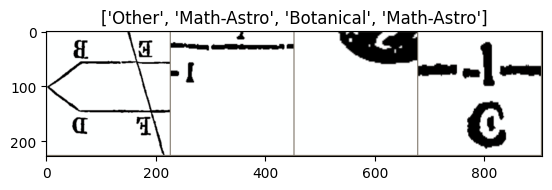

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

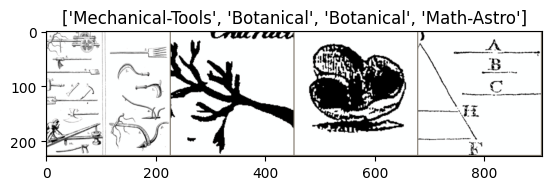

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
class_names

['Anatomical',
 'Architecture',
 'Botanical',
 'Math-Astro',
 'Mechanical-Tools',
 'Other',
 'Zoological']

## Training

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft18 = models.resnet18(pretrained=True)
num_ftrs = model_ft18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft18.fc = nn.Linear(num_ftrs, len(class_names))

model_ft18 = model_ft18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft18.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
model_ft50 = models.resnet50(pretrained=True)
num_ftrs = model_ft50.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft50.fc = nn.Linear(num_ftrs, len(class_names))

model_ft50 = model_ft50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft50 = optim.SGD(model_ft50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft50, step_size=7, gamma=0.1)

/usr/local/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /users/vesalaia/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 102MB/s] 


In [9]:
model_ft18 = train_model(model_ft18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2379 Acc: 0.5754
val Loss: 0.9939 Acc: 0.6750

Epoch 1/24
----------
train Loss: 1.1819 Acc: 0.6126
val Loss: 1.1555 Acc: 0.7050

Epoch 2/24
----------
train Loss: 1.0770 Acc: 0.6342
val Loss: 1.1187 Acc: 0.6650

Epoch 3/24
----------
train Loss: 1.0428 Acc: 0.6520
val Loss: 0.9880 Acc: 0.7000

Epoch 4/24
----------
train Loss: 1.0097 Acc: 0.6516
val Loss: 1.1227 Acc: 0.7100

Epoch 5/24
----------
train Loss: 0.9330 Acc: 0.6977
val Loss: 1.0522 Acc: 0.6400

Epoch 6/24
----------
train Loss: 0.9115 Acc: 0.6880
val Loss: 1.0078 Acc: 0.6950

Epoch 7/24
----------
train Loss: 0.7333 Acc: 0.7401
val Loss: 0.9067 Acc: 0.7250

Epoch 8/24
----------
train Loss: 0.6795 Acc: 0.7561
val Loss: 0.8909 Acc: 0.7350

Epoch 9/24
----------
train Loss: 0.6425 Acc: 0.7739
val Loss: 0.8681 Acc: 0.7550

Epoch 10/24
----------
train Loss: 0.6818 Acc: 0.7595
val Loss: 0.8664 Acc: 0.7600

Epoch 11/24
----------
train Loss: 0.6619 Acc: 0.7625
val Loss: 0.8032 Acc: 0.7600

Ep

In [11]:
model_ft50 = train_model(model_ft50, criterion, optimizer_ft50, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2785 Acc: 0.5703
val Loss: 1.0943 Acc: 0.6450

Epoch 1/24
----------
train Loss: 1.0683 Acc: 0.6266
val Loss: 0.8883 Acc: 0.6950

Epoch 2/24
----------
train Loss: 0.9652 Acc: 0.6685
val Loss: 1.3218 Acc: 0.5650

Epoch 3/24
----------
train Loss: 0.9175 Acc: 0.6744
val Loss: 0.9805 Acc: 0.6950

Epoch 4/24
----------
train Loss: 0.8540 Acc: 0.6931
val Loss: 0.7274 Acc: 0.7400

Epoch 5/24
----------
train Loss: 0.8186 Acc: 0.7049
val Loss: 0.6858 Acc: 0.7750

Epoch 6/24
----------
train Loss: 0.7550 Acc: 0.7341
val Loss: 0.8456 Acc: 0.7400

Epoch 7/24
----------
train Loss: 0.6281 Acc: 0.7714
val Loss: 0.7538 Acc: 0.7650

Epoch 8/24
----------
train Loss: 0.5809 Acc: 0.7870
val Loss: 0.7544 Acc: 0.8000

Epoch 9/24
----------
train Loss: 0.5867 Acc: 0.7917
val Loss: 0.7446 Acc: 0.8000

Epoch 10/24
----------
train Loss: 0.5321 Acc: 0.8137
val Loss: 0.7192 Acc: 0.7850

Epoch 11/24
----------
train Loss: 0.5314 Acc: 0.8116
val Loss: 0.6983 Acc: 0.7900

Ep

In [12]:
torch.save(model_ft18, "/scratch/project_2005488/DHH23/model/model_ft18.pth")
torch.save(model_ft50, "/scratch/project_2005488/DHH23/model/model_ft50.pth")


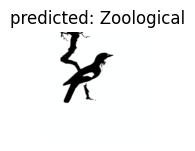

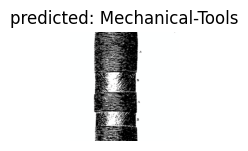

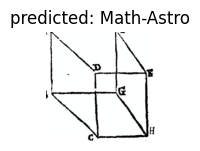

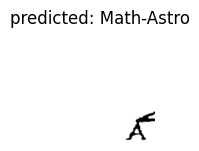

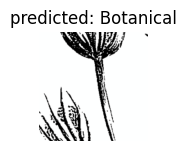

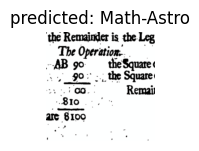

In [13]:
visualize_model(model_ft18)

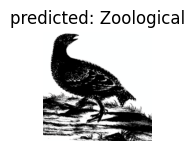

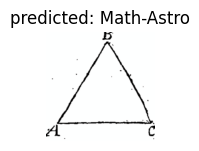

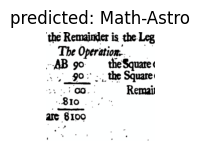

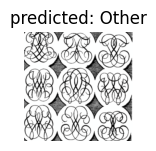

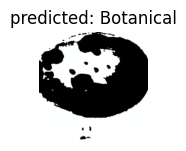

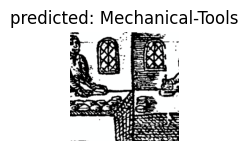

In [14]:
visualize_model(model_ft50)

In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [8]:
model_ft18 = torch.load("/scratch/project_2005488/DHH23/model/model_ft18.pth")
model_ft18.eval()
cnt = 0
err = 0
for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_ft18(inputs)
            _, preds = torch.max(outputs, 1)

            preds = preds.tolist()
            labels = labels.tolist()
            cnt += len(labels)
            for x,y in zip(preds, labels):
                if x!=y:
                    err += 1

print("Total: {} Errors:{} Accuracy:{}".format(cnt, err, 100*(cnt-err)/cnt))

Total: 200 Errors:38 Accuracy:81.0


In [9]:
model_ft50 = torch.load("/scratch/project_2005488/DHH23/model/model_ft50.pth")
model_ft50.eval()
cnt = 0
err = 0
for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_ft50(inputs)
            _, preds = torch.max(outputs, 1)

            preds = preds.tolist()
            labels = labels.tolist()
            cnt += len(labels)
            for x,y in zip(preds, labels):
                if x!=y:
                    err += 1
print("Total: {} Errors:{} Accuracy:{}".format(cnt, err, 100*(cnt-err)/cnt))

Total: 200 Errors:35 Accuracy:82.5


In [10]:
len(inputs)
idx_to_class ={'Anatomical':0,
 'Architecture':1,
 'Botanical':2,
 'Math-Astro':3,
 'Mechanical-Tools':4,
 'Other':5,
 'Zoological':6}

In [11]:
class_names

['Anatomical',
 'Architecture',
 'Botanical',
 'Math-Astro',
 'Mechanical-Tools',
 'Other',
 'Zoological']

In [12]:
def predict(model, test_image_name):
    transform = data_transforms['val']
    test_image = Image.open(test_image_name)
#    plt.imshow(test_image)
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        pred = torch.argmax(out).item()
    return pred

In [13]:
predict(model_ft50, "/scratch/project_2005488/DHH23/early_modern_cropped/Illustration/112000060000080_1.png")

3

In [ ]:
early_modern = "/scratch/project_2005488/DHH23/early_modern_cropped/Illustration"
file_list = os.listdir(early_modern)

early_classifications = []
for cnt, fname in enumerate(file_list):
    file_path = os.path.join(early_modern, fname)
    pred = predict(model_ft50, file_path)
#    print(fname, class_names[pred])
    early_classifications.append([fname, class_names[pred]])

    if cnt % 1000 == 0: print("Number of images: {} classified".format(cnt))


Number of images: 0 classified
Number of images: 1000 classified
Number of images: 2000 classified
Number of images: 3000 classified
Number of images: 4000 classified
Number of images: 5000 classified
Number of images: 6000 classified
Number of images: 7000 classified
Number of images: 8000 classified
Number of images: 9000 classified
Number of images: 10000 classified
Number of images: 11000 classified
Number of images: 12000 classified
Number of images: 13000 classified
Number of images: 14000 classified
Number of images: 15000 classified
Number of images: 16000 classified
Number of images: 17000 classified
Number of images: 18000 classified
Number of images: 19000 classified
Number of images: 20000 classified
Number of images: 21000 classified
Number of images: 22000 classified
Number of images: 23000 classified
Number of images: 24000 classified
Number of images: 25000 classified
Number of images: 26000 classified
Number of images: 27000 classified
Number of images: 28000 classifie

In [15]:
import pandas as pd

header_list = ['Image', 'Category']

df = pd.DataFrame(clip_classifications, columns=header_list)
df

,Image,Category
0,120040010108040_0.png,Botanical
1,042570140003550_0.png,Math-Astro
2,027900080000910_0.png,Math-Astro
3,108140010003130_1.png,Math-Astro
4,014880210003390_1.png,Math-Astro
5,119990030001950_0.png,Zoological
6,020300080006930_0.png,Math-Astro


In [16]:
df.to_csv('/scratch/project_2005488/DHH23/early_modern_annotations.csv', index=False)